# Binary classification with un-balanced data

Make sure to download all lessons and notebooks - will come offline

#!pip install

In this notebook, we learn the problems we run into when training a classifier to predict rare events. Many binary classification problems involve rare events, such as predicting that someone has a rare disease, or predicting that someone looking at an add will buy the product. When one of the classes (by convention the positive class) makes up only a very small percentage of the data and most data points belong to the other class (by convention the negative class), we call the uncommon class a **rare event** and we say that we have **unbalanced data**. We explore in this notebook how to unbalanced data affects the way that we evaluate the model.

The Boston dataset has housing data including median house price. We create a binary label to flag the most expensive houses and build a classifier to predict the likelihood of a house being expensive.

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
boston = load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

Note that the `boston` object above is a Python dictionary, which include the features `boston['data']`, the target which is the housing price in `boston['target']`, and additional metadata, such a a description.

Let's visualize the first few rows of the `boston` data.

In [3]:
boston['data'][1:5]

array([[2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        7.1850e+00, 6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9283e+02, 4.0300e+00],
       [3.2370e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
        6.9980e+00, 4.5800e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
        1.8700e+01, 3.9463e+02, 2.9400e+00],
       [6.9050e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
        7.1470e+00, 5.4200e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
        1.8700e+01, 3.9690e+02, 5.3300e+00]])

As you can see this is not very pretty. The reason is that `boston` is a Python array, similar to a matrix. Of course, at the end of the day all tabular data is turned into an array so that we can do linear algebra with it, but for the sake of visualization this is not ideal. The solution is to take the raw array and turn it into a `DataFrame` using `pandas`, which was created for this purpose. It allows us to interact with the data in a more code-friendly and intuitive way. This is why we say `DataFrame` is an **abstraction layer** on top of `numpy` so data scientists can do their most common tasks without having to use `numpy` directly.

In [4]:
df_boston = pd.DataFrame(boston['data'], columns = boston['feature_names'])
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### Exercise (4 minutes)

- As one example, recall that earlier in the notebook we used `np.unique(...)` to get counts. Use it to get counts for each unique value of the `RAD` column in `df_boston`, in other words `df_boston['RAD']`.

In [5]:
unique_values, unique_counts = np.unique(df_boston['RAD'],return_index=False, return_inverse=False, return_counts=True)

In [6]:
unique_values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., 24.])

In [7]:
unique_counts

array([ 20,  24,  38, 110, 115,  26,  17,  24, 132], dtype=int64)

- Now turn the counts into percentages instead.

In [8]:
unique_percent = unique_counts / unique_counts.sum()
unique_percent

array([0.03952569, 0.04743083, 0.07509881, 0.2173913 , 0.22727273,
       0.0513834 , 0.03359684, 0.04743083, 0.26086957])

- Since getting counts and turning them into percentages is such a common data-related task, there's got to be an easier way to do it. And there is. Search online to see if `pandas` offers a function for getting unique counts for a column in the data. Can you turn the counts into percentages?

In [9]:
df_boston['RAD'].value_counts(normalize=True)

24.0    0.260870
5.0     0.227273
4.0     0.217391
3.0     0.075099
6.0     0.051383
8.0     0.047431
2.0     0.047431
1.0     0.039526
7.0     0.033597
Name: RAD, dtype: float64

### End of exercise

Let's now visualize the target variable, housing price.

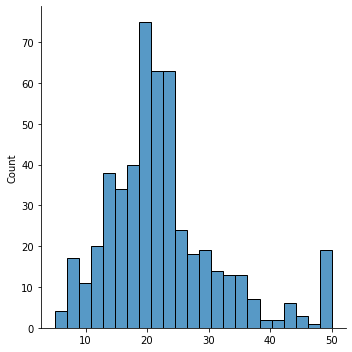

In [10]:
ax = sns.displot(boston['target'])

Say we're interested in training a classification algorithm to predict whether or not a house is worth 40k or more. So first we create a target column in the data that flags houses who sold for 40k or more.

In [11]:
df_boston['is_above_40k'] = boston['target'] >= 40

In [12]:
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,is_above_40k
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,False
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,False
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,False
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,False
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,False


We start by splitting `df_boston` into a training data and a testing data. The easiest way to do this is using the `train_test_split` function.

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_boston.drop(columns = 'is_above_40k'), 
                                                    df_boston['is_above_40k'], 
                                                    test_size = 0.20, 
                                                    random_state = 0)

### Exercise (6 minutes)

Find counts for `is_above_40k`.

In [14]:
df_boston['is_above_40k'].value_counts()

False    475
True      31
Name: is_above_40k, dtype: int64

Train a logistic regression classifier to predict when the price of a house is above 40k. Begin by loading the library as such: `from sklearn.linear_model import LogisticRegression`. Then create an instance of the algorithm and train it by invoking the `.fit(x_train, y_train)`.

In [15]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=5000)

logit.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

Once the model is trained, pass it the testing data to see if we get predictions back. To do so, we invoke the `.predict(x_test)` method. We can also invoke the `.predict_proba(x_test)` method if we wish to get the raw probabilites instead of the final predictions.

In [16]:
logit.predict(x_test)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [17]:
logit.predict_proba(x_test)

array([[9.99784284e-01, 2.15716378e-04],
       [9.99297088e-01, 7.02911918e-04],
       [9.99996384e-01, 3.61626316e-06],
       [1.00000000e+00, 2.75041647e-10],
       [9.99999994e-01, 6.26664978e-09],
       [9.99999505e-01, 4.95203047e-07],
       [9.99997995e-01, 2.00518709e-06],
       [9.99999657e-01, 3.42836455e-07],
       [9.99999833e-01, 1.66725986e-07],
       [9.99996384e-01, 3.61550299e-06],
       [9.99955805e-01, 4.41945842e-05],
       [9.99999999e-01, 5.26513298e-10],
       [9.99999999e-01, 6.27714146e-10],
       [1.00000000e+00, 2.79159105e-16],
       [5.57098488e-03, 9.94429015e-01],
       [9.76479437e-01, 2.35205626e-02],
       [9.99994980e-01, 5.01972926e-06],
       [7.06092140e-01, 2.93907860e-01],
       [8.82771653e-01, 1.17228347e-01],
       [9.99993115e-01, 6.88493922e-06],
       [9.99968789e-01, 3.12105909e-05],
       [9.99994290e-01, 5.70983365e-06],
       [9.99999999e-01, 1.27633485e-09],
       [9.99128521e-01, 8.71479404e-04],
       [9.999995

Get the accuracy of the model by loading `from sklearn.metrics import accuracy_score` and calling the `accuracy_score` function. What two arguments do we pass to this function to evaluate the model's accuracy?

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, logit.predict(x_test))

0.9509803921568627

Is accuracy a good metric for evaluating this model? Why or why not? To give some context, let's say you're a developer and want to predict house prices. You prefer to bid low and lose a bid than bid high for a house that's not worth it.

### End of exercise

Let's find some more useful evaluation metrics. The most direct metric to look at, is the confusion matrix.

In [19]:
from sklearn import metrics
y_test_pred = logit.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_test_pred)
print(cm)

[[93  2]
 [ 3  4]]


From the confusion matrix, we can derive accuracy, precision, recall, and the F1-score, which is a sort of average of precision and recall. We don't have time to get into all of them in detail, but [here](http://www.win-vector.com/blog/2009/11/i-dont-think-that-means-what-you-think-it-means-statistics-to-english-translation-part-1-accuracy-measures/) is an excellent article explaining in great detail the differences between each.

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97        95
        True       0.67      0.57      0.62         7

    accuracy                           0.95       102
   macro avg       0.82      0.78      0.79       102
weighted avg       0.95      0.95      0.95       102



One way to visually evaluate a binary classification model is using the ROC plot. By itself, it is not very useful, but by comparing the ROC plot of multiple models we can start seeing which models are better. The area under the ROC plot is called AUC (area under the curve) and the closer it is to 1, the better the model.

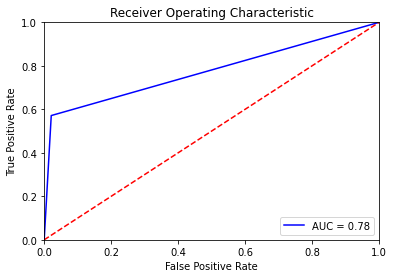

In [21]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Assignment

In this assignment, we want to implement cross-validation for logistic regression. Cross-validation is a powerful technique for model selection (such as when choosing the right hyper-parameters), especially when the data size is not very large. The goal of this assignment is to first implement cross-validation and compare it to a baseline model (with no cross-validation).

1. Refactor the code from the lab and train and evaluate the `LogisticRegression` classifier just like we did in the lab. <span style="color:red" float:right>[2 point]</span>

In [22]:
from sklearn.datasets import load_boston
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report

In [23]:
boston = load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [24]:
df_boston = pd.DataFrame(boston['data'], columns = boston['feature_names'])
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [25]:
df_boston['is_above_40k'] = boston['target'] >= 40

In [26]:
###Maybe to get different accuracy scores potentially scale the data

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_boston.drop(columns = 'is_above_40k'), 
                                                    df_boston['is_above_40k'], 
                                                    test_size = 0.20, 
                                                    random_state = 0)

In [28]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=5000)

logit.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

In [29]:
accuracy_score(y_test, logit.predict(x_test))

0.9509803921568627

In [30]:
accuracy_score(y_test, logit.predict(x_test))
y_test_pred = logit.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_test_pred)
print(cm)

[[93  2]
 [ 3  4]]


In [31]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97        95
        True       0.67      0.57      0.62         7

    accuracy                           0.95       102
   macro avg       0.82      0.78      0.79       102
weighted avg       0.95      0.95      0.95       102



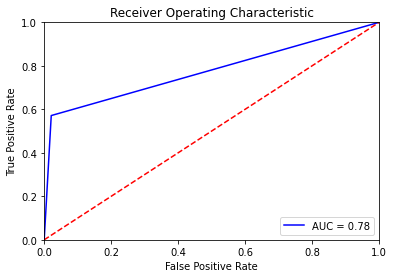

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

2. The `LogisticRegression` classifier has an argument called `class_weight`. Read the documentation to see what it does, then train a new model this time by providing the class weights. <span style="color:red" float:right>[2 point]</span>

#https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work

#https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

It penalizes mistakes in samples of class[i] instead of 1. Higher class-weight means you want to put more emphasis on a class. By using class_weight = 'balanced', you can capture more true events with less false alerts

In [33]:
logit_class_weight = LogisticRegression(max_iter=5000, class_weight='balanced')

logit_class_weight.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000)

In [34]:
accuracy_score(y_test, logit_class_weight.predict(x_test))

0.9215686274509803

In [35]:
y_test_pred_cw = logit_class_weight.predict(x_test)
cm_cw = metrics.confusion_matrix(y_test, y_test_pred_cw)
print(cm_cw)

[[90  5]
 [ 3  4]]


In [36]:
print(classification_report(y_test, y_test_pred_cw))

              precision    recall  f1-score   support

       False       0.97      0.95      0.96        95
        True       0.44      0.57      0.50         7

    accuracy                           0.92       102
   macro avg       0.71      0.76      0.73       102
weighted avg       0.93      0.92      0.93       102



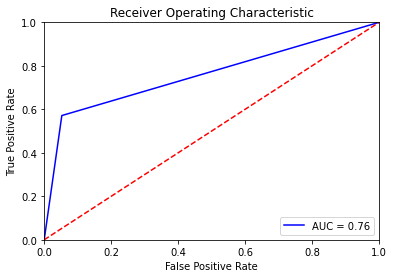

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_cw)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

3. Does it change any of the results? In what way? <span style="color:red" float:right>[2 point]</span>

Decreases the accuracy by about 2%

Add quantifiable code here to show - talk about differences of the tables - True drops to 57
Talk about the metrics of the model and why they are different

In [38]:
print(classification_report(y_test, y_test_pred))
##Focus in on the f1-score and then also the recall
#recall and precision is something you need to look into

              precision    recall  f1-score   support

       False       0.97      0.98      0.97        95
        True       0.67      0.57      0.62         7

    accuracy                           0.95       102
   macro avg       0.82      0.78      0.79       102
weighted avg       0.95      0.95      0.95       102



In [39]:
print(classification_report(y_test, y_test_pred_cw))

              precision    recall  f1-score   support

       False       0.97      0.95      0.96        95
        True       0.44      0.57      0.50         7

    accuracy                           0.92       102
   macro avg       0.71      0.76      0.73       102
weighted avg       0.93      0.92      0.93       102



4. Return to the training step but use `LogisticRegressionCV` this time (the CV stands for cross-validation). <span style="color:red" float:right>[1 point]</span>

In [40]:
from sklearn.linear_model import LogisticRegressionCV
##Normalize the data to see potential differences
logit_CV = LogisticRegressionCV(max_iter=50000) # Had to increase the number of iterations

logit_CV.fit(x_train, y_train)

###maybe add a train, test split here!!!!

#x_train, x_test, y_train, y_test = train_test_split(df_boston.drop(columns = 'is_above_40k'), 
#                                                    df_boston['is_above_40k'], 
#                                                    test_size = 0.20, 
#                                                    random_state = 0)

LogisticRegressionCV(max_iter=50000)

In [41]:
accuracy_score(y_test, logit_CV.predict(x_test)) #Ask about this one!!!! - same score as q1

0.9411764705882353

In [42]:
y_test_pred_CV = logit_CV.predict(x_test)
cm_CV = metrics.confusion_matrix(y_test, y_test_pred_CV)
print(cm_CV)

[[92  3]
 [ 3  4]]


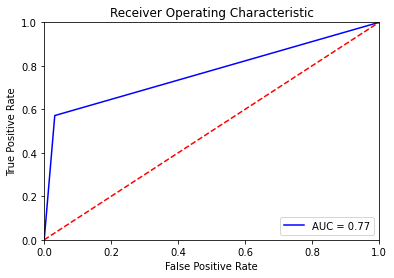

In [43]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_CV)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

5. Does cross-validation seem to make a difference in the results we get? <span style="color:red" float:right>[2 point]</span>

#Add quantifiable code here to show - talk about differences of the tables - True drops to 57

6. Change the number of folds from 5 to 10 and train the CV model again? Notice any difference in performance? Note that *performance* here refers to the model's overall accuracy, based on your choice of metric, it does NOT refer to run-time. <span style="color:red" float:right>[3 point]</span>

In [44]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
cv_5 = KFold(n_splits=5)#Need to set random_state or shuffle??
cv_10=KFold(n_splits=10)#Need to set random_state or shuffle??

In [45]:
model_5 = LogisticRegressionCV(max_iter=5000000)
model_10 = LogisticRegressionCV(max_iter=5000000)

In [46]:
score_5=cross_val_score(model_5, x_train, y_train, scoring='accuracy', cv=cv_5, n_jobs=1)
score_10=cross_val_score(model_10, x_train, y_train, scoring='accuracy', cv=cv_10, n_jobs=1)

In [29]:
logit_CV_10_balanced = LogisticRegressionCV(max_iter=50000, cv=10, class_weight='balanced') # Had to increase the number of iterations
logit_CV_5_balanced = LogisticRegressionCV(max_iter=50000, cv=5, class_weight='balanced') # Had to increase the number of iterations


In [30]:
logit_CV_10_balanced.fit(x_train, y_train)
logit_CV_5_balanced.fit(x_train, y_train)


LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=50000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [38]:
logit_CV_10_unbalanced = LogisticRegressionCV(max_iter=50000, cv=10) # Had to increase the number of iterations
logit_CV_5_unbalanced = LogisticRegressionCV(max_iter=50000, cv=5)

In [39]:
logit_CV_10_unbalanced.fit(x_train, y_train)
logit_CV_5_unbalanced.fit(x_train, y_train)


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=50000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

7. What was the cost of increasing the number of folds in terms of run-time? <span style="color:red" float:right>[2 point]</span>

In [40]:
%%timeit 
logit_CV_10_unbalanced.fit(x_train, y_train)

15.2 s ± 56.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%%timeit
logit_CV_5_unbalanced.fit(x_train, y_train)

8.59 s ± 87.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# End of assignment